In [1]:
import torch
import numpy as np
import random
import os
import time
import copy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from torch.optim import AdamW

# CHANGED: Import RoBERTa instead of BERT
from transformers import RobertaForSequenceClassification

# Fix random seeds for reproducibility
SEED = 50
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# CHANGED: Path points to the RoBERTa encoder data
DATA_PATH = "/content/drive/MyDrive/DNLP/data/processed_data/sentiment_roberta_encoder_data.pt"
WEIGHTS_PATH = "/content/drive/MyDrive/DNLP/data/processed_data/sentiment_weights.pt" # Weights likely shared or similar

encoder_data = torch.load(DATA_PATH)
class_weights = torch.load(WEIGHTS_PATH).to(device)

print("Keys in loaded data:", encoder_data.keys())
print("Loaded class weights:", class_weights)

Mounted at /content/drive
Keys in loaded data: dict_keys(['train', 'val', 'test'])
Loaded class weights: tensor([0.9912, 1.0090], device='cuda:0')


In [3]:
class SentimentDataset(Dataset):
    def __init__(self, split_data):
        self.input_ids = split_data["input_ids"]
        self.attention_mask = split_data["attention_mask"]
        self.labels = split_data["labels"]
        self.variety = split_data["variety"]
        self.source = split_data["source"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
            "variety": self.variety[idx],
            "source": self.source[idx]
        }

In [4]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0

    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # RoBERTa forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            all_logits.append(outputs.logits)
            all_labels.append(labels)

    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    preds = torch.argmax(all_logits, dim=1).cpu().numpy()
    true_labels = all_labels.cpu().numpy()

    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average="macro")

    return acc, f1

def filter_data_by_source(data_split, source_id):
    indices = (data_split["source"] == source_id).nonzero(as_tuple=True)[0]
    filtered_data = {}
    for key in data_split:
        if isinstance(data_split[key], torch.Tensor):
            filtered_data[key] = data_split[key][indices]
        else:
            filtered_data[key] = data_split[key]
    return filtered_data

In [ ]:
# Configuration
CHECKPOINT_DIR = "/content/drive/MyDrive/DNLP/checkpoints"
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# CHANGED: Updated file names for RoBERTa
params = [
    {"name": "Google", "id": 0, "save_file": "best_roberta_sentiment_google.pt", "hist_file": "history_roberta_google.pt"},
    {"name": "Reddit", "id": 1, "save_file": "best_roberta_sentiment_reddit.pt", "hist_file": "history_roberta_reddit.pt"}
]

NUM_EPOCHS = 30
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
PATIENCE = 5

for param in params:
    SOURCE_NAME = param["name"]
    SOURCE_ID = param["id"]
    SAVE_PATH = f"{CHECKPOINT_DIR}/{param['save_file']}"

    print(f"\n{'='*40}")
    print(f" Training RoBERTa on {SOURCE_NAME} (ID: {SOURCE_ID})")
    print(f"{'='*40}\n")

    # 1. Filter Data
    train_sub = filter_data_by_source(encoder_data["train"], SOURCE_ID)
    val_sub = filter_data_by_source(encoder_data["val"], SOURCE_ID)

    if len(train_sub["labels"]) == 0:
        print(f"No data found for {SOURCE_NAME}!")
        continue

    train_dl = DataLoader(SentimentDataset(train_sub), batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(SentimentDataset(val_sub), batch_size=BATCH_SIZE, shuffle=False)

    # 2. Setup RoBERTa Model
    # CHANGED: roberta-base
    model = RobertaForSequenceClassification.from_pretrained(
        "roberta-base",
        num_labels=2
    )
    model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

    # 3. Training Loop
    history = {"train_loss": [], "val_acc": [], "val_f1": []}
    best_val_f1 = 0.0
    epochs_no_improve = 0

    epoch_bar = tqdm(range(1, NUM_EPOCHS + 1), desc=f"{SOURCE_NAME} Training")

    for epoch in epoch_bar:
        train_loss = train_one_epoch(model, train_dl, optimizer, loss_fn, device)
        val_acc, val_f1 = evaluate(model, val_dl, device)

        history["train_loss"].append(train_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        epoch_bar.set_postfix({"loss": f"{train_loss:.4f}", "val_f1": f"{val_f1:.4f}"})

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            epochs_no_improve = 0
            torch.save(model.state_dict(), SAVE_PATH)
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch}.")
            break

    print(f"Best {SOURCE_NAME} F1: {best_val_f1:.4f}")
    torch.save(history, f"{CHECKPOINT_DIR}/{param['hist_file']}")

    del model, optimizer
    torch.cuda.empty_cache()


 Training RoBERTa on Google (ID: 0)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Google Training:   0%|          | 0/30 [00:00<?, ?it/s]


Early stopping at epoch 10.
Best Google F1: 0.9360

 Training RoBERTa on Reddit (ID: 1)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Reddit Training:   0%|          | 0/30 [00:00<?, ?it/s]


Early stopping at epoch 9.
Best Reddit F1: 0.8326


In [5]:
model_paths = {
    "Google": f"{CHECKPOINT_DIR}/best_roberta_sentiment_google.pt",
    "Reddit": f"{CHECKPOINT_DIR}/best_roberta_sentiment_reddit.pt"
}
source_ids = {"Google": 0, "Reddit": 1}

results = []

print(f"{'='*60}")
print(" STARTING ROBERTA CROSS-DOMAIN EVALUATION")
print(f"{'='*60}\n")

for model_name, model_path in model_paths.items():
    if not os.path.exists(model_path):
        continue

    # Load RoBERTa
    model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    for test_source_name, test_source_id in source_ids.items():
        test_sub = filter_data_by_source(encoder_data["test"], test_source_id)
        test_dl = DataLoader(SentimentDataset(test_sub), batch_size=BATCH_SIZE, shuffle=False)

        acc, f1 = evaluate(model, test_dl, device)

        results.append({
            "Trained On": model_name,
            "Tested On": test_source_name,
            "Accuracy": acc,
            "F1 Score": f1,
            "Type": "Same Domain" if model_name == test_source_name else "Cross Domain"
        })

    del model
    torch.cuda.empty_cache()

df_results = pd.DataFrame(results)

# --- HEATMAP PLOT ---
heatmap_data = df_results.pivot(index="Trained On", columns="Tested On", values="F1 Score")
plt.figure(figsize=(8, 6))
sns.set_theme(style="white")
ax = sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="Blues", vmin=0.5, vmax=1.0,
                 cbar_kws={'label': 'Macro F1 Score'},
                 annot_kws={"size": 14, "weight": "bold"},
                 linewidths=1, linecolor='black')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.title("RoBERTa Cross-Domain Performance Matrix", fontsize=16, pad=20)
plt.show()

NameError: name 'CHECKPOINT_DIR' is not defined

In [10]:
import torch
import os
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast

# 1. Configuration
CHECKPOINT_DIR = "/content/drive/MyDrive/DNLP/checkpoints"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Choose the file you want to load:
# Options: "best_roberta_sentiment_google.pt" OR "best_roberta_sentiment_reddit.pt"
model_filename = "best_roberta_sentiment_google.pt"
model_path = os.path.join(CHECKPOINT_DIR, model_filename)

print(f"{'='*60}")
print(f" LOADING MODEL: {model_filename}")
print(f"{'='*60}\n")

if os.path.exists(model_path):
    # 2. Re-create the RoBERTa Architecture
    model = RobertaForSequenceClassification.from_pretrained(
        "roberta-base",
        num_labels=2
    )

    # 3. Load the saved weights
    # map_location ensures it loads on CPU if GPU is missing
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # 4. Move to device and set to Eval mode
    model.to(device)
    model.eval()

    print("✅ Model loaded successfully!")

    # 5. Load Tokenizer (Required if you want to test new sentences)
    tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
    print("✅ Tokenizer loaded.")

else:
    print(f"❌ Error: File not found at {model_path}")
    print("Check your Google Drive path or ensure training finished.")

 LOADING MODEL: best_roberta_sentiment_google.pt



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully!


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

✅ Tokenizer loaded.


In [12]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch

# 1. Load the Data Tensors
# Ensure this path matches the 'sentiment' file, not sarcasm
DATA_PATH = "/content/drive/MyDrive/DNLP/data/processed_data/sentiment_roberta_encoder_data.pt"
encoder_data = torch.load(DATA_PATH)

# 2. Define Dataset Class (Same as training)
class SentimentDataset(Dataset):
    def __init__(self, split_data):
        self.input_ids = split_data["input_ids"]
        self.attention_mask = split_data["attention_mask"]
        self.labels = split_data["labels"]
        self.source = split_data["source"] # Include source for analysis

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
            "source": self.source[idx]
        }

# 3. Create Test Loader
test_dataset = SentimentDataset(encoder_data["test"])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"✅ Test Data Loaded: {len(test_dataset)} samples ready for evaluation.")

✅ Test Data Loaded: 1212 samples ready for evaluation.


Running inference on test set...

 RESULTS SUMMARY
Accuracy: 0.8853
Macro F1: 0.8853


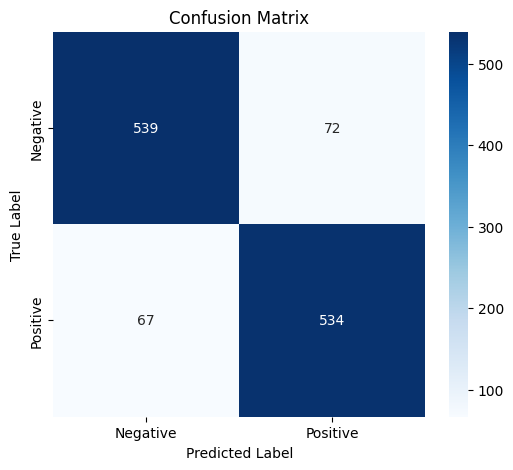

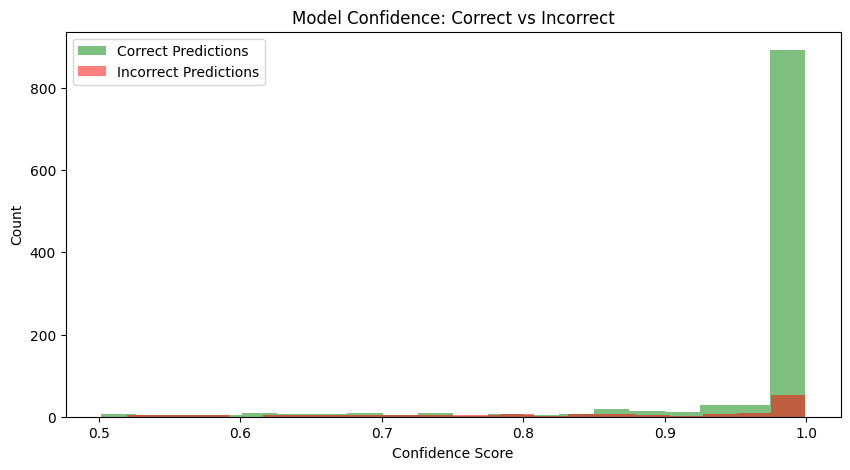


 TOP 5 'CONFIDENTLY WRONG' EXAMPLES
Rank 1 | Source: Reddit
Text: "I dropped out of my science degree, so I'm personally a bad example LOL. But because I was part of a Science cohort, and now work at the uni I dropped out of, I happen to have a lot of Science uni friends. I will say no one is making the big bucks. Don't know anyone doing astrophysics though, only know of a handful of PhD students in that field, all were from relatively prestigious universities in their undergraduate, or participated in some institutional research projects prior to their PhD. Some anecdotal stories about my friends who are science grads. My best friend did a double degree in Chemistry and Commerce, has always been smart and hardworking, now works for Sydney Water with a salary of $109K. My partner is a Forensic Science major, with skills leaning towards chemistry. I told him on our first year of dating (when we were 19 years old) that he wasn't going to find a job in that field - it's an impossible fie

In [13]:
def analyze_model_performance(model, dataloader, tokenizer, device):
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []
    all_sources = []
    mistakes = []

    print("Running inference on test set...")

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            sources = batch["source"]

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=mask)

            # Calculate probabilities and predictions
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Store results
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy()) # Keep full prob vector
            all_sources.extend(sources.numpy())

            # Find Mistakes in this batch for deep analysis
            incorrect_mask = preds != labels
            incorrect_indices = incorrect_mask.nonzero(as_tuple=True)[0]

            for idx in incorrect_indices:
                text_id = input_ids[idx]
                # Decode text
                text = tokenizer.decode(text_id, skip_special_tokens=True)

                mistakes.append({
                    "text": text,
                    "true": labels[idx].item(),
                    "pred": preds[idx].item(),
                    "conf": probs[idx][preds[idx]].item(), # Confidence in the WRONG answer
                    "source": "Reddit" if sources[idx].item() == 1 else "Google"
                })

    # --- 1. METRICS & CONFUSION MATRIX ---
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")

    print(f"\n{'='*40}")
    print(f" RESULTS SUMMARY")
    print(f"{'='*40}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # --- 2. CONFIDENCE HISTOGRAM ---
    # We want to see if the model is "sure" when it's right/wrong
    correct_confs = [p[l] for p, l in zip(all_probs, all_labels) if np.argmax(p) == l]
    wrong_confs = [m['conf'] for m in mistakes]

    plt.figure(figsize=(10, 5))
    plt.hist(correct_confs, bins=20, alpha=0.5, color='green', label='Correct Predictions')
    plt.hist(wrong_confs, bins=20, alpha=0.5, color='red', label='Incorrect Predictions')
    plt.xlabel('Confidence Score')
    plt.ylabel('Count')
    plt.title('Model Confidence: Correct vs Incorrect')
    plt.legend()
    plt.show()

    # --- 3. TOP ERROR ANALYSIS ---
    # Sort mistakes by confidence (High confidence errors are the worst)
    mistakes.sort(key=lambda x: x['conf'], reverse=True)

    print(f"\n{'='*40}")
    print(f" TOP 5 'CONFIDENTLY WRONG' EXAMPLES")
    print(f"{'='*40}")

    label_map = {0: "Negative", 1: "Positive"}

    for i, m in enumerate(mistakes[:5]):
        print(f"Rank {i+1} | Source: {m['source']}")
        print(f"Text: \"{m['text']}\"")
        print(f"True: {label_map[m['true']]} | Pred: {label_map[m['pred']]} (Confidence: {m['conf']:.2f})")
        print("-" * 60)

# Run the analysis
import numpy as np # Ensure numpy is imported
analyze_model_performance(model, test_loader, tokenizer, device)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Analyzing vocabulary triggers...


/tmp/ipython-input-1459949131.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[1] for x in neg_counts], y=[x[0] for x in neg_counts], ax=axes[0], palette="Reds_r")
/tmp/ipython-input-1459949131.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[1] for x in pos_counts], y=[x[0] for x in pos_counts], ax=axes[1], palette="Greens_r")


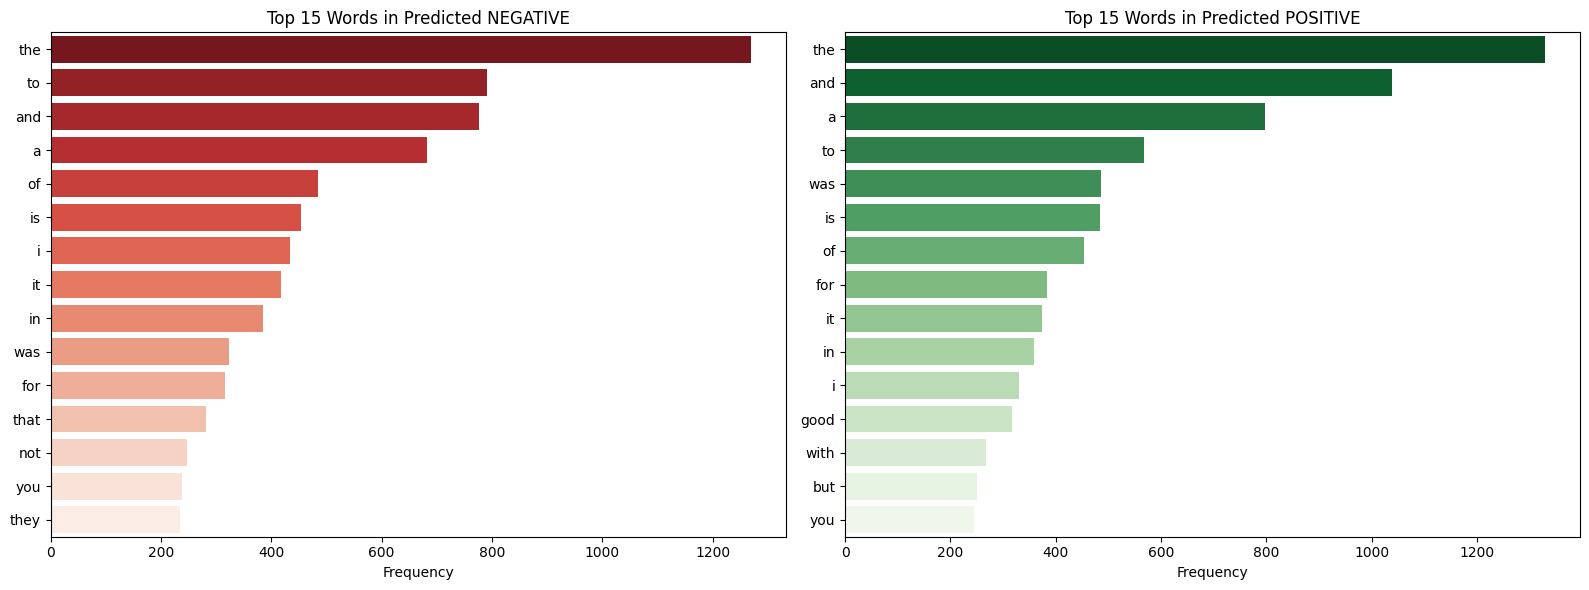

In [14]:
from collections import Counter
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Download stopwords (run once)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def plot_sentiment_triggers(model, dataloader, tokenizer, device, top_n=15):
    model.eval()
    pos_tokens = []
    neg_tokens = []

    print("Analyzing vocabulary triggers...")

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)

            # Get predictions
            outputs = model(input_ids=input_ids, attention_mask=mask)
            preds = torch.argmax(outputs.logits, dim=1)

            # Iterate through each sample in batch
            for i in range(len(input_ids)):
                # Convert IDs to tokens
                tokens = tokenizer.convert_ids_to_tokens(input_ids[i])

                # Clean tokens: remove special chars ('Ġ', '<s>'), padding, and stopwords
                clean_tokens = [
                    t.replace('Ġ', '').lower() for t in tokens
                    if t.isalpha() and t.lower() not in stop_words and t not in ['<s>', '</s>', '<pad>']
                ]

                # Separate into Positive (1) and Negative (0) buckets
                if preds[i] == 1:
                    pos_tokens.extend(clean_tokens)
                else:
                    neg_tokens.extend(clean_tokens)

    # Count most frequent words
    pos_counts = Counter(pos_tokens).most_common(top_n)
    neg_counts = Counter(neg_tokens).most_common(top_n)

    # --- PLOTTING ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Negative Triggers Plot
    sns.barplot(x=[x[1] for x in neg_counts], y=[x[0] for x in neg_counts], ax=axes[0], palette="Reds_r")
    axes[0].set_title(f"Top {top_n} Words in Predicted NEGATIVE")
    axes[0].set_xlabel("Frequency")

    # Positive Triggers Plot
    sns.barplot(x=[x[1] for x in pos_counts], y=[x[0] for x in pos_counts], ax=axes[1], palette="Greens_r")
    axes[1].set_title(f"Top {top_n} Words in Predicted POSITIVE")
    axes[1].set_xlabel("Frequency")

    plt.tight_layout()
    plt.show()

# Run it
plot_sentiment_triggers(model, test_loader, tokenizer, device)

/tmp/ipython-input-2655146180.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_acc = df.groupby('Bin')['Correct'].mean()


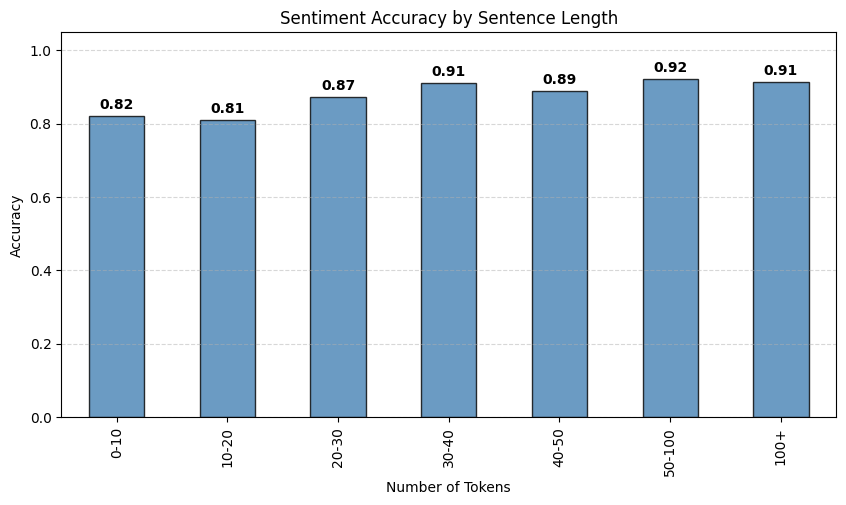

In [15]:
import pandas as pd

def plot_accuracy_by_length(model, dataloader, device):
    model.eval()
    lengths = []
    correct_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Get predictions
            preds = torch.argmax(model(input_ids=input_ids, attention_mask=mask).logits, dim=1)

            # Calculate real sentence length (ignoring padding)
            batch_lengths = mask.sum(dim=1).cpu().numpy()
            is_correct = (preds == labels).cpu().numpy()

            lengths.extend(batch_lengths)
            correct_preds.extend(is_correct)

    # Create DataFrame
    df = pd.DataFrame({'Length': lengths, 'Correct': correct_preds})

    # Group lengths into bins (e.g., 0-10 words, 10-20 words...)
    bins = [0, 10, 20, 30, 40, 50, 100, 512]
    labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-100', '100+']
    df['Bin'] = pd.cut(df['Length'], bins=bins, labels=labels)

    # Calculate average accuracy per bin
    bin_acc = df.groupby('Bin')['Correct'].mean()

    # --- PLOTTING ---
    plt.figure(figsize=(10, 5))
    bin_acc.plot(kind='bar', color='steelblue', alpha=0.8, edgecolor='black')
    plt.title('Sentiment Accuracy by Sentence Length')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Add numbers on bars
    for i, v in enumerate(bin_acc):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

    plt.show()

# Run it
plot_accuracy_by_length(model, test_loader, device)


Performance by Platform:
          Accuracy  Macro F1  Count
Platform                           
Google    0.915423  0.887106  603.0
Reddit    0.855501  0.806270  609.0


/tmp/ipython-input-2633122417.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('Platform').apply(


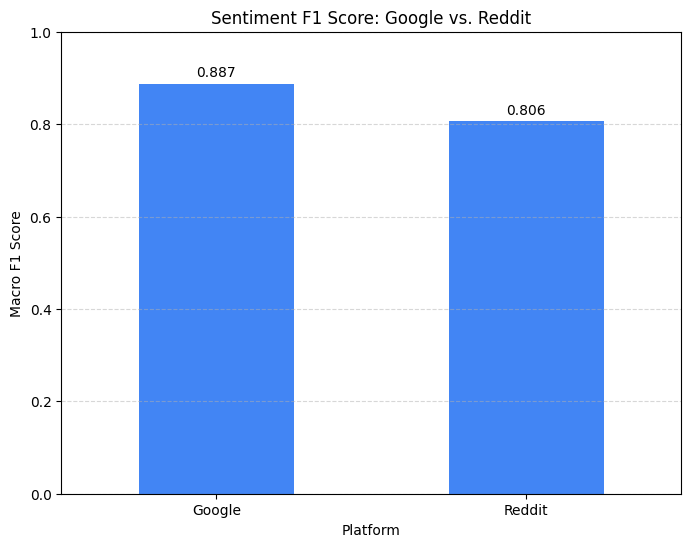

In [16]:
from sklearn.metrics import accuracy_score, f1_score

def compare_sources(model, dataloader, device):
    model.eval()
    all_preds, all_labels, all_sources = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            sources = batch["source"]

            preds = torch.argmax(model(input_ids=input_ids, attention_mask=mask).logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_sources.extend(sources.numpy())

    # Create DataFrame
    df = pd.DataFrame({'Label': all_labels, 'Pred': all_preds, 'Source_ID': all_sources})

    # Map IDs to Names (Assuming 0=Google, 1=Reddit based on previous context)
    source_map = {0: 'Google', 1: 'Reddit'}
    df['Platform'] = df['Source_ID'].map(source_map)

    # Calculate Metrics for each platform
    results = df.groupby('Platform').apply(
        lambda x: pd.Series({
            'Accuracy': accuracy_score(x['Label'], x['Pred']),
            'Macro F1': f1_score(x['Label'], x['Pred'], average='macro'),
            'Count': len(x)
        })
    )

    print("\nPerformance by Platform:")
    print(results)

    # --- PLOTTING ---
    ax = results[['Macro F1']].plot(kind='bar', color=['#4285F4', '#FF4500'], figsize=(8, 6), legend=False)
    plt.title('Sentiment F1 Score: Google vs. Reddit')
    plt.ylabel('Macro F1 Score')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Add labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)

    plt.show()

# Run it
compare_sources(model, test_loader, device)

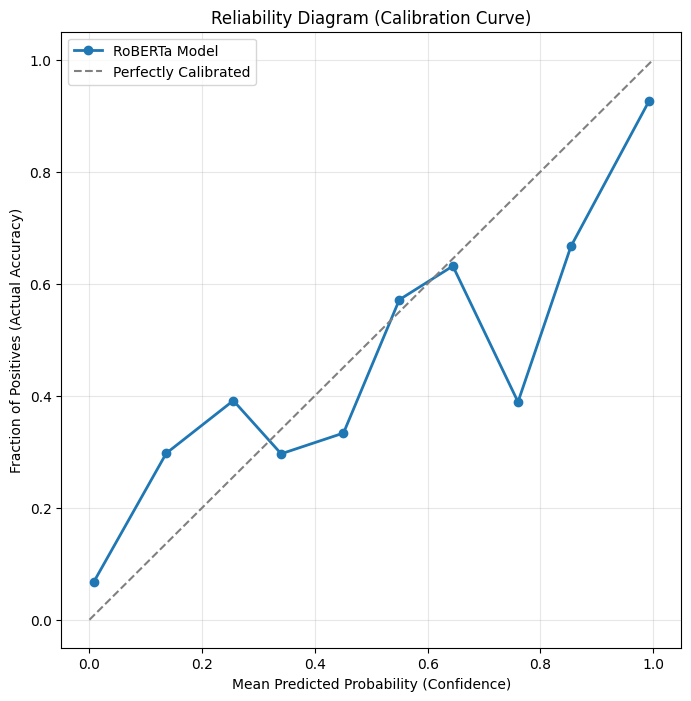

In [17]:
from sklearn.calibration import calibration_curve

def plot_calibration(model, dataloader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=mask)
            # Get probability for Class 1 (Positive)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)[:, 1]

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate calibration
    prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)

    # --- PLOTTING ---
    plt.figure(figsize=(8, 8))
    plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='RoBERTa Model')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

    plt.xlabel('Mean Predicted Probability (Confidence)')
    plt.ylabel('Fraction of Positives (Actual Accuracy)')
    plt.title('Reliability Diagram (Calibration Curve)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run it
plot_calibration(model, test_loader, device)